In [82]:
from pathlib import Path
from pandas import read_parquet
from json import load
from pandas import concat, DataFrame, Series
import matplotlib.pyplot as plt

import seaborn as sns

In [74]:
path = Path(r"C:\Users\Maxximiser\Downloads\test")

def load_data(directory: Path, pattern: str):
   timings = {}
   metadata = {}
   for file in directory.glob(f"{pattern}"):
      filename_segments = file.stem.split("_")
      file_key = f"{filename_segments[1]}_{filename_segments[3]}"
      if file.suffix == ".parquet":
         timings[file_key] = read_parquet(file)
      elif file.suffix == ".json":
         with file.open() as file_handle:
            metadata[file_key] = load(file_handle)
      else:
         print(f"Ignoring unknown file `{file}`")
   missing = set(timings.keys()).difference(set(metadata.keys()))
   if len(missing) > 0:
      print(f"Missing files: {missing}")
   return timings, metadata

def find_fastest(dataframe: DataFrame, column_name):
   return dataframe[dataframe[column_name] == dataframe[column_name].min()]

def preprocess_cpu(row: Series, metadata, duration_column):
   row_key = f"{row['sparse_format']}_{row['operation_method']}"
   row_metadata = metadata[row_key]
   number = row_metadata["number"]
   if row["device"] == "cpu":
      iterations = row_metadata["function_iterations"]
      row[duration_column] = row[duration_column] / number / iterations
   elif row["device"] == "gpu":
      row[duration_column] = row[duration_column] / number
   else:
      raise ValueError(f"Unknown device `{row['device']}`")
   return row

In [81]:
cpu_timings, cpu_metadata = load_data(path, "cpu*")
cpu_fastest = concat(
   [find_fastest(timings, "duration") for timings in cpu_timings.values()]
)
cpu_fastest = cpu_fastest.apply(preprocess_cpu, axis=1, args=(cpu_metadata, "duration"))
cpu_fastest["duration"] = cpu_fastest["duration"] * 1_000
cpu_fastest

,device,operation_method,sparse_format,duration
3,cpu,iterative,bsr,10.663240
7,cpu,once,bsr,10.598284
5,cpu,iterative,csc,1.877446
9,cpu,once,csc,1.873908
7,cpu,iterative,csr,1.974540
5,cpu,once,csr,1.972487


<Axes: xlabel='sparse_format', ylabel='duration'>

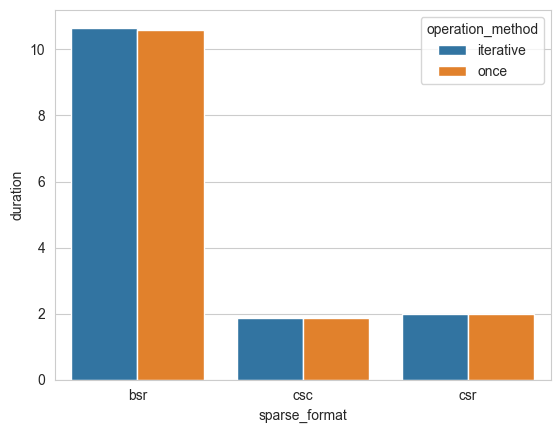

In [78]:
sns.barplot(cpu_fastest, x="sparse_format", y="duration", hue="operation_method")

In [75]:
gpu_timings, gpu_metadata = load_data(path, "gpu*")
gpu_fastest = concat(
   [find_fastest(timings, "duration_gpu") for timings in gpu_timings.values()]
)
gpu_fastest = gpu_fastest.apply(preprocess_cpu, axis=1, args=(gpu_metadata, "duration_gpu"))
gpu_fastest["duration_gpu"] = gpu_fastest["duration_gpu"] * 1_000
gpu_fastest
# gpu_timings["csr_once"].min()

,device,operation_method,sparse_format,duration_cpu,duration_gpu
4,gpu,iterative,coo,22.204807,22.209842
7220,gpu,once,coo,0.015978,21.987904
9,gpu,iterative,csc,0.100073,0.173259
1878,gpu,once,csc,0.000290,0.192032
7,gpu,iterative,csr,0.107278,0.311062
400,gpu,once,csr,0.000121,0.234208


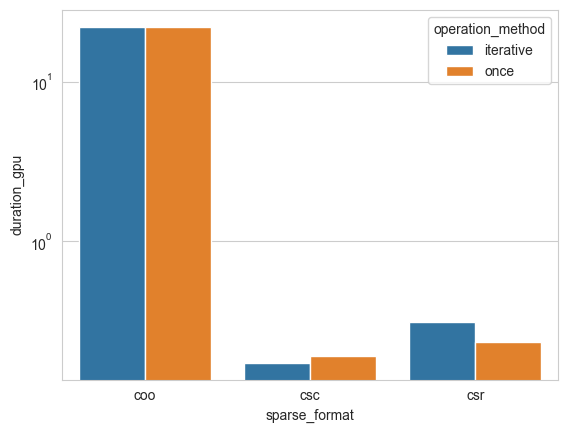

In [85]:
sns.barplot(gpu_fastest, x="sparse_format", y="duration_gpu", hue="operation_method")
plt.yscale("log")